In [1]:
import glob

from fastai.text import *
# from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *
#torch.backends.cudnn.enabled=False #for quant.313v machine.  Not sure why...

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0609'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['funniness_average'] = 0
test_df['funniness_average'].iloc[0] = 0.1
test_df['funniness_average'].iloc[1] = 1.2
test_df['funniness_average'].iloc[2] = 3.4
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='funniness_average')

In [4]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_regr_0609_fld*.pth')]
len(model_wt_fnames)

100

In [5]:
!grep Reg ./prod/out_regr_tmp101.txt > ./by_seed_reg_perf

In [6]:
!head by_seed_reg_perf

Reg Fold: 0 RndSeed: 952742,0.556799054145813
Reg Fold: 1 RndSeed: 952742,0.527113139629364
Reg Fold: 2 RndSeed: 952742,0.5140876770019531
Reg Fold: 3 RndSeed: 952742,0.5316392779350281
Reg Fold: 4 RndSeed: 952742,0.5504149198532104
Reg Fold: 0 RndSeed: 443926,0.5491292476654053
Reg Fold: 1 RndSeed: 443926,0.5375394225120544
Reg Fold: 2 RndSeed: 443926,0.5298753380775452
Reg Fold: 3 RndSeed: 443926,0.5300775170326233
Reg Fold: 4 RndSeed: 443926,0.5408030152320862


In [7]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_reg_perf', names = ['id','mse'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf['nfold'] = valid_perf.id.str.split(' ',expand=True).iloc[:,2]
valid_perf.head()

,id,mse,rnd_seed,nfold
0,Reg Fold: 0 RndSeed: 952742,0.556799,952742,0
1,Reg Fold: 1 RndSeed: 952742,0.527113,952742,1
2,Reg Fold: 2 RndSeed: 952742,0.514088,952742,2
3,Reg Fold: 3 RndSeed: 952742,0.531639,952742,3
4,Reg Fold: 4 RndSeed: 952742,0.550415,952742,4


Text(0.5, 1.0, 'Freq of mse over all Random Seeds (20) \n Vert line = min MSE')

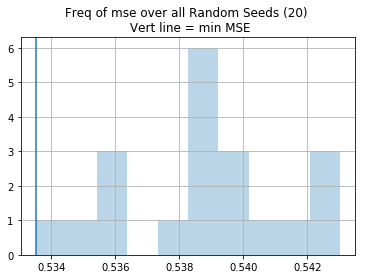

In [8]:
# valid_perf.mse.hist(alpha=0.3)
# plt.axvline(x=valid_perf.mse.quantile(0.25))
valid_perf.groupby('rnd_seed')['mse'].mean().hist(alpha=0.3)
plt.axvline(x=valid_perf.groupby('rnd_seed')['mse'].mean().min())

#valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].F1.hist(alpha=0.3)
plt.title('Freq of mse over all Random Seeds (20) \n Vert line = min MSE')

In [14]:
seed_grouped_F1 = valid_perf.groupby('rnd_seed')['mse'].mean()
selected_seeds = seed_grouped_F1[seed_grouped_F1<=seed_grouped_F1.min()].index.values.tolist()
seed_fold_pair = valid_perf[valid_perf.rnd_seed.isin(selected_seeds)].loc[:,['rnd_seed','nfold']].values
model_wt_fnames = []
for (seed,fold) in seed_fold_pair:
    model_wt_fnames.append(f'haha_regr_0609_fld{fold}_{seed}.pth')
model_wt_fnames

['haha_regr_0609_fld0_460304.pth',
 'haha_regr_0609_fld1_460304.pth',
 'haha_regr_0609_fld2_460304.pth',
 'haha_regr_0609_fld3_460304.pth',
 'haha_regr_0609_fld4_460304.pth']

In [15]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [16]:
np.array(ensemble_preds).shape

(5, 6000, 1)

In [17]:
np.array(ensemble_preds)[:5,...]

array([[[ 1.165335],
        [ 0.045733],
        [ 2.459762],
        [ 0.161045],
        ...,
        [ 0.689134],
        [-0.03462 ],
        [ 1.361915],
        [ 1.511036]],

       [[ 1.357982],
        [ 0.364403],
        [ 2.286914],
        [ 0.232941],
        ...,
        [ 0.592691],
        [ 0.052261],
        [ 1.149296],
        [ 1.93051 ]],

       [[ 1.311042],
        [ 0.207793],
        [ 2.817587],
        [ 0.22541 ],
        ...,
        [ 0.932663],
        [ 0.044561],
        [ 1.164979],
        [ 1.197653]],

       [[ 1.154597],
        [ 0.233841],
        [ 2.387934],
        [ 0.07883 ],
        ...,
        [ 0.601854],
        [-0.020627],
        [ 1.117711],
        [ 1.520425]],

       [[ 1.121697],
        [ 0.187215],
        [ 2.193333],
        [ 0.061356],
        ...,
        [ 0.540405],
        [ 0.111036],
        [ 1.061157],
        [ 1.530687]]], dtype=float32)

In [18]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[1.222131],
       [0.207797],
       [2.429106],
       [0.151917],
       ...,
       [0.671349],
       [0.030522],
       [1.171012],
       [1.538062]], dtype=float32)

In [19]:
out_df = pd.read_csv('sub0610_finetune_bestSeed.csv')
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [20]:
out_df.shape, ens_mean.shape

((6000, 3), (6000, 1))

In [21]:
out_df.funniness_average = ens_mean

In [22]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,1.222131
1,tweet2,0,0.207797
2,tweet3,1,2.429106
3,tweet4,0,0.151917
4,tweet5,0,-0.169308


In [23]:
out_df.to_csv('sub0610_finetune_bestSeed.csv',header=True,index=False)

In [25]:
!zip  sub0610_finetune_bestSeed.zip sub0610_finetune_bestSeed.csv 

  adding: sub0610_finetune_bestSeed.csv (deflated 66%)


In [26]:
!cp sub0610_finetune_bestSeed.zip /mnt/awcnas4_AWX/tmp/